# Real Estate Stock Analysis
Intro

In [292]:
#Import the required libraries and dependencies
import os
import sys
import datetime
import requests
import json
import numpy as np
import pandas as pd
import panel as pn
from panel.interact import interact
from panel import widgets
from dotenv import load_dotenv
import hvplot.pandas
%matplotlib inline

from MCForecastTools import MCSimulation

In [293]:
#Extention for plotly visualization tool
pn.extension("plotly")

In [294]:
#Load enviroment variables
load_dotenv()

True

## API to pull stock information into DF - Polygon

In [295]:
#Set Polygon API key
polygon_api_key = os.getenv("POLYGON_API")

#Verify that Polygon key is loaded correctly
print(f"Polygon Key type:{type(polygon_api_key)}")

Polygon Key type:<class 'str'>


In [145]:
#Make an API call to access the current prices for BEKE, OPEN, RDFN, Z, EXPI, AMT, CBRE, WY, ESS, AVB, ARE and SPY. (Credits: Binoy Das - Slack post)
def fetch_stock_aggregates(tickers, multiplier=1, timespan="day", start_date='', end_date='', columns=['Close'], key=polygon_api_key):

    column_mappings = {'c': 'Close', 'h': 'High', 'l':'Low', 'n':'Transactions', 'o':'Open', 'v':'Volume', 'vw':'Adjusted'}
    data_frames = {}    
    if end_date == '':
        end_date = datetime.date.today().strftime('%Y-%m-%d')
    if start_date == '':
        start_date = (datetime.date.today()-datetime.timedelta(days=1)).strftime('%Y-%m-%d')    
        
    for ticker in tickers:
        if 'polygon' in sys.modules:                
            with RESTClient(key) as polygon_client:
                response_json = polygon_client.stocks_equities_aggregates(ticker, multiplier, timespan, start_date, end_date, limit=50000)
                stock_df = pd.DataFrame(response_json.results)
                print(f"{timespan.capitalize()} aggregates for {response_json.ticker} between {start_date} and {end_date} fetched.")
        else:
            url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}?sort=asc&limit=50000&apiKey={key}"
            print(url)
            response_json = requests.get(url).json()
            stock_df = pd.DataFrame(response_json['results'])
            print(f"{timespan.capitalize()} aggregates for {response_json['ticker']} between {start_date} and {end_date} fetched.")
        
        stock_df["Date"] = pd.to_datetime(stock_df["t"].div(1000), unit='s')
        stock_df = stock_df.drop(['t'], axis=1)
        stock_df = stock_df.set_index("Date")
        
        column_names = []
        for column in stock_df.columns:
            if column in column_mappings.keys():
                column_name = column_mappings[column]
            if column_name in columns:
                column_names.append(column_name)
            else:
                stock_df = stock_df.drop([column], axis=1)
        stock_df.columns = column_names
        data_frames[ticker] = stock_df
        
    merged_df = pd.concat(data_frames.values(), axis=1, keys=data_frames.keys())
    merged_df=merged_df.dropna()
    
    return merged_df

In [146]:
#Since we are using free version of Polygon only 5 requests can be pushed at ones or per minute. Only 2 years of data available.
#Second half is ran in later function('AMT', 'CBRE', 'WY', 'ESS', 'AVB') 

In [147]:
#Fetching Polygon data and converting it to pct_change at the same time (Credits: Binoy Das - Slack post
stock_df = fetch_stock_aggregates(['BEKE', 'OPEN', 'RDFN', 'Z', 'EXPI'], start_date='2021-01-01')
df = pd.DataFrame()
for col in stock_df.columns:
    df[col[0]] = stock_df[col[0]][col[1]]
df = df.pct_change()

#Reviewing df
df.head()

https://api.polygon.io/v2/aggs/ticker/BEKE/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for BEKE between 2021-01-01 and 2022-04-09 fetched.
https://api.polygon.io/v2/aggs/ticker/OPEN/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for OPEN between 2021-01-01 and 2022-04-09 fetched.
https://api.polygon.io/v2/aggs/ticker/RDFN/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for RDFN between 2021-01-01 and 2022-04-09 fetched.
https://api.polygon.io/v2/aggs/ticker/Z/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for Z between 2021-01-01 and 2022-04-09 fetched.
https://api.polygon.io/v2/aggs/ticker/EXPI/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for EXPI between 2021-01-01 and 2

,BEKE,OPEN,RDFN,Z,EXPI
Date,,,,,
2021-01-04 05:00:00,NaN,NaN,NaN,NaN,NaN
2021-01-05 05:00:00,0.073552,0.066222,0.026175,0.037279,0.021828
2021-01-06 05:00:00,0.000972,0.054688,-0.011014,-0.007114,-0.031245
2021-01-07 05:00:00,0.018770,0.041852,0.053781,0.054277,0.087214
2021-01-08 05:00:00,0.036849,-0.047636,0.063969,0.018452,0.125473


In [148]:
#Fetching second part of Polygon data and converting it to pct_change at the same time (Credits to Binoy Das)
stock_df = fetch_stock_aggregates(['AMT', 'CBRE', 'WY', 'ESS', 'AVB'], start_date='2021-01-01')
part2_df = pd.DataFrame()
for col in stock_df.columns:
    part2_df[col[0]] = stock_df[col[0]][col[1]]
part2_df = part2_df.pct_change()
part2_df.head()

https://api.polygon.io/v2/aggs/ticker/AMT/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for AMT between 2021-01-01 and 2022-04-09 fetched.
https://api.polygon.io/v2/aggs/ticker/CBRE/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for CBRE between 2021-01-01 and 2022-04-09 fetched.
https://api.polygon.io/v2/aggs/ticker/WY/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for WY between 2021-01-01 and 2022-04-09 fetched.
https://api.polygon.io/v2/aggs/ticker/ESS/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for ESS between 2021-01-01 and 2022-04-09 fetched.
https://api.polygon.io/v2/aggs/ticker/AVB/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for AVB between 2021-01-01 and 2022-

,AMT,CBRE,WY,ESS,AVB
Date,,,,,
2021-01-04 05:00:00,NaN,NaN,NaN,NaN,NaN
2021-01-05 05:00:00,0.005055,-0.001345,0.009448,-0.004513,-0.002894
2021-01-06 05:00:00,-0.026369,0.020027,0.005133,0.041590,0.026827
2021-01-07 05:00:00,0.012146,0.014684,0.009612,-0.021845,-0.013628
2021-01-08 05:00:00,0.021609,0.018537,-0.006843,0.010324,0.008786


In [151]:
#Fetching second part of Polygon data and converting it to pct_change at the same time(Credits to Binoy Das)
stock_df = fetch_stock_aggregates(['SPY'], start_date='2021-01-01')
sp500_df = pd.DataFrame()
for col in stock_df.columns:
    sp500_df[col[0]] = stock_df[col[0]][col[1]]
sp500_df = sp500_df.pct_change()
sp500_df.head()

https://api.polygon.io/v2/aggs/ticker/SPY/range/1/day/2021-01-01/2022-04-09?sort=asc&limit=50000&apiKey=fkzdg7p1rESznhN5hXBJMVIEM8hfNYqd
Day aggregates for SPY between 2021-01-01 and 2022-04-09 fetched.


,SPY
Date,
2021-01-04 05:00:00,NaN
2021-01-05 05:00:00,0.006887
2021-01-06 05:00:00,0.005979
2021-01-07 05:00:00,0.014857
2021-01-08 05:00:00,0.005698


In [250]:
#Concat two data frames into one DF
all_stocks_df = pd.concat(
    [df, part2_df, sp500_df], 
    axis="columns",
    sort=False
)

#Reviewing merged stock df
all_stocks_df

,BEKE,OPEN,RDFN,Z,EXPI,AMT,CBRE,WY,ESS,AVB,SPY
Date,,,,,,,,,,,
2021-01-04 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 05:00:00,0.073552,0.066222,0.026175,0.037279,0.021828,0.005055,-0.001345,0.009448,-0.004513,-0.002894,0.006887
2021-01-06 05:00:00,0.000972,0.054688,-0.011014,-0.007114,-0.031245,-0.026369,0.020027,0.005133,0.041590,0.026827,0.005979
2021-01-07 05:00:00,0.018770,0.041852,0.053781,0.054277,0.087214,0.012146,0.014684,0.009612,-0.021845,-0.013628,0.014857
2021-01-08 05:00:00,0.036849,-0.047636,0.063969,0.018452,0.125473,0.021609,0.018537,-0.006843,0.010324,0.008786,0.005698
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04 04:00:00,0.172734,0.068396,0.037122,0.089720,0.069779,0.003425,0.005669,0.019989,-0.010184,-0.013481,0.008567
2022-04-05 04:00:00,-0.060256,-0.078366,-0.055617,-0.023443,-0.087276,0.019742,-0.014417,-0.023981,-0.002658,-0.006255,-0.012631
2022-04-06 04:00:00,0.012953,-0.092216,-0.056560,-0.055118,-0.064419,0.021680,-0.021117,-0.009511,0.018197,0.022089,-0.009999


In [269]:
#Trying to figure out how to drop time from Date column

#all_stocks_df = pd.DatetimeIndex(all_stocks_df.T).normalize()
#all_stocks_df = all_stocks_df.T.all_stocks_df.normalize()
#all_stocks_df['Date'] = pd.to_datetime(all_stocks_df['Date']).dt.date

#all_stocks_df = all_stocks_df.rename(columns={"Index": "Date"})
#all_stocks_df.head()

In [154]:
#Plotting daily returns on all 10 portfolios.
all_stocks_df.hvplot(
    xlabel="Trading Days", 
    ylabel= "Daily Returns", 
    title="Daily Returns on 10 Real Estate Stocks over period in 1/2021-4/2022",
    width=1000, 
    height=500
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

## Quantitative Analysis

In [240]:
#Dropping first NA row from DF
all_stocks_df.dropna(inplace=True)

In [241]:
#Calculating and plotting the cumulative returns of the 10 portfolios  and S&P 500
cumulative_returns = (1 + all_stocks_df).cumprod()

#Reviewing the first 5 rows of the cumulative returns DataFrame
cumulative_returns.head()

,BEKE,OPEN,RDFN,Z,EXPI,AMT,CBRE,WY,ESS,AVB,SPY
Date,,,,,,,,,,,
2021-01-05 05:00:00,1.073552,1.066222,1.026175,1.037279,1.021828,1.005055,0.998655,1.009448,0.995487,0.997106,1.006887
2021-01-06 05:00:00,1.074596,1.124531,1.014872,1.029900,0.989901,0.978552,1.018655,1.014630,1.036889,1.023855,1.012907
2021-01-07 05:00:00,1.094766,1.171595,1.069453,1.085799,1.076234,0.990437,1.033613,1.024383,1.014239,1.009902,1.027956
2021-01-08 05:00:00,1.135107,1.115785,1.137864,1.105835,1.211272,1.011840,1.052773,1.017373,1.024710,1.018776,1.033813
2021-01-11 05:00:00,1.117893,1.092461,1.149018,1.094976,1.196938,0.978689,1.046050,1.008839,1.013275,1.011960,1.026845


In [238]:
#Visualizing the cumulative returns using the Pandas hvplot function
cumulative_returns.hvplot(
    xlabel="Trading Days", 
    ylabel="Cumulative Return", 
    title="Cumulative Returns 1/2021-4/2022",
    width=1000, 
    height=500
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [158]:
#YTD returns/drop index column
df_bar = pd.DataFrame({"Stock": cumulative_returns.columns, "Return": (cumulative_returns.iloc[-1]-1).mul(100)})
df_bar = df_bar.reset_index().drop(["index"], axis=1)

#Reviewing the DataFrame
df_bar

,Stock,Return
0,BEKE,-73.535037
1,OPEN,-69.679300
2,RDFN,-77.186199
3,Z,-63.539038
4,EXPI,-44.942173
5,AMT,21.316029
6,CBRE,45.277311
7,WY,17.890887
8,ESS,53.971522
9,AVB,60.500257


In [159]:
#Plotting the new data frame
df_bar.hvplot.bar(x="Stock", y="Return", xlabel="Stock", ylabel="YTD Return")

:Bars   [Stock]   (Return)

<AxesSubplot:title={'center':'Real Estate Stocks Portfolio Box Chart'}>

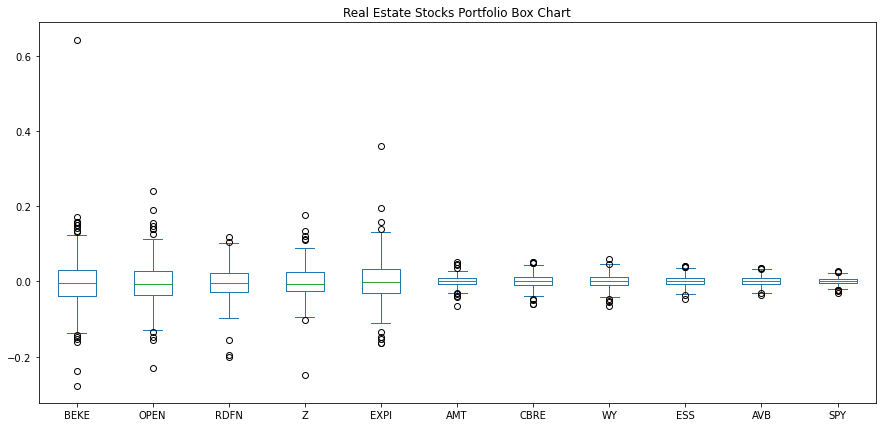

In [160]:
#Created box plot to reflect the return data for all Real Estate Stocks
all_stocks_df.plot.box(figsize = (15,7), title= "Real Estate Stocks Portfolio Box Chart")

In [161]:
#Calculating Standard deviation for all 10 potfolios and SPY
standard_deviation = all_stocks_df.std()
standard_deviation.sort_values()

SPY     0.009480
AVB     0.012503
AMT     0.013914
ESS     0.014200
WY      0.017490
CBRE    0.018087
Z       0.040542
RDFN    0.043206
OPEN    0.055750
EXPI    0.056824
BEKE    0.071957
dtype: float64

In [162]:
#Calculating the annualized standard deviation (252 trading days) 
#Reviewing the annual standard deviations from smallest to largest
annualized_standard_deviation = standard_deviation * np.sqrt(252)
annualized_standard_deviation.sort_values()

SPY     0.150491
AVB     0.198483
AMT     0.220871
ESS     0.225413
WY      0.277640
CBRE    0.287121
Z       0.643590
RDFN    0.685873
OPEN    0.885009
EXPI    0.902059
BEKE    1.142277
dtype: float64

In [291]:
#Plotting 21-day rolling standard deviation(months SMA)
all_stocks_sma_21 = all_stocks_df.rolling(window=21).std()

#Plotting the stocks df with a 21-day rolling window 
all_stocks_sma_21.hvplot(title="Portfolios 21-Day SMA", width=1000, height=500)


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [164]:
#Calculating Average annual return for Sharpe ratio
average_annual_return = all_stocks_df.mean() * 252

#Average annual return sorted lowest to highest
average_annual_return.sort_values()

RDFN   -0.925664
Z      -0.586411
OPEN   -0.551316
BEKE   -0.434829
EXPI   -0.073164
SPY     0.164287
WY      0.168595
AMT     0.177048
CBRE    0.336249
ESS     0.366483
AVB     0.393638
dtype: float64

In [165]:
#We calculate the annualized Sharpe Ratios for each of the portfolios and the S&P 500.
sharpe_ratios = average_annual_return/annualized_standard_deviation

#Sharpe ratios sorted lowest to highest
sharpe_ratios.sort_values()

RDFN   -1.349615
Z      -0.911156
OPEN   -0.622949
BEKE   -0.380669
EXPI   -0.081108
WY      0.607244
AMT     0.801588
SPY     1.091676
CBRE    1.171107
ESS     1.625826
AVB     1.983235
dtype: float64

In [290]:
#Visualizing Bar plotting of Sharpe Ratios
sharpe_ratios.hvplot.bar(
    height=500,
    width=1000,
    xlabel= "Stocks", 
    ylabel="Sharpe Ratio", 
    title= "Sharpe Ratios")

:Bars   [index]   (0)

In [167]:
#Based on the analysis and visualization of Sharpe Ratio, we would recomend CBRE, ESS, AVB as investment options.
#Now we will need to evaluate how the portfolios react relative to the broader market SPY. 

In [168]:
#Calculate the variance of the S&P 500 using a rolling 60-day window.
snp_rolling_60_variance = all_stocks_df["SPY"].rolling(window=60).var()
snp_rolling_60_variance.tail()

Date
2022-04-04 04:00:00    0.000184
2022-04-05 04:00:00    0.000186
2022-04-06 04:00:00    0.000188
2022-04-07 04:00:00    0.000187
2022-04-08 04:00:00    0.000186
Name: SPY, dtype: float64

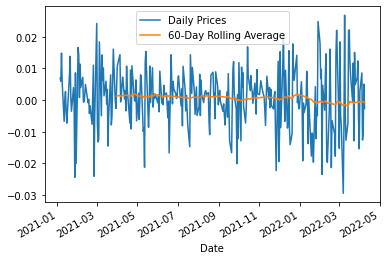

In [169]:
#Set the plot of SPY's daily prices as the main plot in the overlay
ax= all_stocks_df["SPY"].plot()

#Plot the 60-day rolling metric as an overlay on the plot
all_stocks_df["SPY"].rolling(window=60).mean().plot(ax=ax)

#Create the legend for the figure
ax.legend(["Daily Prices", "60-Day Rolling Average"])

## AVB

In [170]:
#Calculate the covariance using a 60-day rolling window 
avb_rolling_60_covariance = all_stocks_df["AVB"].rolling(window=60).cov(all_stocks_df["SPY"])
avb_rolling_60_covariance.tail()

Date
2022-04-04 04:00:00    0.000123
2022-04-05 04:00:00    0.000124
2022-04-06 04:00:00    0.000120
2022-04-07 04:00:00    0.000118
2022-04-08 04:00:00    0.000118
dtype: float64

In [171]:
#Calculate the beta based on the 60-day rolling covariance compared to the market (S&P 500)
avb_rolling_60_beta = avb_rolling_60_covariance/snp_rolling_60_variance
avb_rolling_60_beta.tail()

Date
2022-04-04 04:00:00    0.671042
2022-04-05 04:00:00    0.665759
2022-04-06 04:00:00    0.641712
2022-04-07 04:00:00    0.632121
2022-04-08 04:00:00    0.630536
dtype: float64

In [245]:
avb_rolling_60_beta.describe()

count    260.000000
mean       0.664224
std        0.145757
min        0.373700
25%        0.552229
50%        0.683591
75%        0.789093
max        0.927931
dtype: float64

In [172]:
#Calculate the average of the 60-day rolling beta
avb_rolling_60_beta.mean()

0.6642237625942606

In [173]:
#Plot the rolling beta 
avb_plot = avb_rolling_60_beta.hvplot(title="AVB INC - 60-Day Rolling Beta")

#Visualizing 60-day rolling window Beta
avb_plot

:Curve   [Date]   (0)

## ESS

In [174]:
#Calculate the covariance using a 60-day rolling window 
ess_rolling_60_covariance = all_stocks_df["ESS"].rolling(window=60).cov(all_stocks_df["SPY"])

#Reviewing last 5 of the 60-day covariance DataFrame
ess_rolling_60_covariance.tail()

Date
2022-04-04 04:00:00    0.000121
2022-04-05 04:00:00    0.000121
2022-04-06 04:00:00    0.000118
2022-04-07 04:00:00    0.000117
2022-04-08 04:00:00    0.000116
dtype: float64

In [175]:
#Calculate the beta based on the 60-day rolling covariance compared to the market (S&P 500)
ess_rolling_60_beta = ess_rolling_60_covariance/snp_rolling_60_variance
ess_rolling_60_beta.tail()

Date
2022-04-04 04:00:00    0.658777
2022-04-05 04:00:00    0.649391
2022-04-06 04:00:00    0.629113
2022-04-07 04:00:00    0.625008
2022-04-08 04:00:00    0.622993
dtype: float64

In [244]:
ess_rolling_60_beta.describe()

count    260.000000
mean       0.790369
std        0.162563
min        0.416194
25%        0.689131
50%        0.813031
75%        0.912512
max        1.056028
dtype: float64

In [176]:
#Calculate the average of the 60-day rolling beta
ess_rolling_60_beta.mean()

0.7903693396496089

In [177]:
#Plot the rolling beta 
ess_plot= ess_rolling_60_beta.hvplot(title="ESS INC - 60-Day Rolling Beta")
ess_plot

:Curve   [Date]   (0)

## CBRE

In [178]:
#Calculate the covariance using a 60-day rolling window 
cbre_rolling_60_covariance = all_stocks_df["CBRE"].rolling(window=60).cov(all_stocks_df["SPY"])
cbre_rolling_60_covariance.tail()

Date
2022-04-04 04:00:00    0.000205
2022-04-05 04:00:00    0.000207
2022-04-06 04:00:00    0.000210
2022-04-07 04:00:00    0.000205
2022-04-08 04:00:00    0.000204
dtype: float64

In [179]:
#Calculate the beta based on the 60-day rolling covariance compared to the market (S&P 500)
cbre_rolling_60_beta = cbre_rolling_60_covariance/snp_rolling_60_variance
cbre_rolling_60_beta.tail()

Date
2022-04-04 04:00:00    1.115524
2022-04-05 04:00:00    1.113157
2022-04-06 04:00:00    1.119668
2022-04-07 04:00:00    1.096077
2022-04-08 04:00:00    1.092477
dtype: float64

In [243]:
cbre_rolling_60_beta.describe()

count    260.000000
mean       1.173384
std        0.215662
min        0.744040
25%        1.001423
50%        1.177383
75%        1.323259
max        1.604847
dtype: float64

In [180]:
#Calculate the average of the 60-day rolling beta
cbre_rolling_60_beta.mean()

1.1733835592387993

In [181]:
#Plot the rolling beta 
cbre_plot = cbre_rolling_60_beta.hvplot(title="CBRE INC - 60-Day Rolling Beta")
cbre_plot

:Curve   [Date]   (0)

## ?Trying to combine Beta calculations in to DRY code?

In [182]:
#Calculating all 3 portolio's covariance using a 60-day rolling window 
rolling_60_covariance = all_stocks_df[["AVB", "ESS", "CBRE"]].rolling(window=60).cov(all_stocks_df["SPY"])
rolling_60_covariance.tail()

,AVB,ESS,CBRE
Date,,,
2022-04-04 04:00:00,0.000123,0.000121,0.000205
2022-04-05 04:00:00,0.000124,0.000121,0.000207
2022-04-06 04:00:00,0.000120,0.000118,0.000210
2022-04-07 04:00:00,0.000118,0.000117,0.000205
2022-04-08 04:00:00,0.000118,0.000116,0.000204


In [296]:
#Option 1/Calculating covariance for all 3 stocks
avb = rolling_60_covariance["AVB"]/snp_rolling_60_variance
ess = rolling_60_covariance["ESS"]/snp_rolling_60_variance
cbre = rolling_60_covariance["CBRE"]/snp_rolling_60_variance

In [308]:
#Column needs to have Stock name!
rolling_60_beta = pd.concat(
    [avb, ess, cbre], 
    axis= "columns",
    sort=False
)
rolling_60_beta.tail()

,0,1,2
Date,,,
2022-04-04 04:00:00,0.671042,0.658777,1.115524
2022-04-05 04:00:00,0.665759,0.649391,1.113157
2022-04-06 04:00:00,0.641712,0.629113,1.119668
2022-04-07 04:00:00,0.632121,0.625008,1.096077
2022-04-08 04:00:00,0.630536,0.622993,1.092477


In [332]:
#Option 2/Error on axis values
#Calculating the beta for all 3 porfolios based on the 60-day rolling covariance compared to the market (S&P 500)
rolling_60_beta = pd.concat(
    [rolling_60_covariance["AVB"]/snp_rolling_60_variance],
    [rolling_60_covariance["ESS"]/snp_rolling_60_variance],
    [rolling_60_covariance["CBRE"]/snp_rolling_60_variance],
    axis="columns",
    sort=False
)
rolling_60_beta.tail()

/Users/olgakoryachek/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



TypeError: concat() got multiple values for argument 'axis'

## OPTION 1/Composed an overlay plot of the AVB, ESS, CBRE Betas

In [333]:
#Overlay Plot of all Betas to compare one to another.?Correct Zero label in the R upper conner
overlay_plot = cbre_plot * ess_plot * avb_plot 
overlay_plot.opts(
    title="60-Day Rolling Beta Overlay Plot for AVB, ESS, CBRE",  
    width=1000, 
    height=500
)

:Overlay
   .Curve.A_0.I   :Curve   [Date]   (0)
   .Curve.A_0.II  :Curve   [Date]   (0)
   .Curve.A_0.III :Curve   [Date]   (0)

## OPTION 2/Composed an BAR overlay plot of the AVB, ESS, CBRE Betas

In [280]:
#Tried using xformatter="%Y%m%d in opts to format date. No chart appears and error given. Ask TA?
#Used xlim to trim data to 3/31/2021 as a start, error only takes tuples. Ask TA?
avb_plot_bar = avb_rolling_60_beta.hvplot.bar(title="AVB INC - 60-Day Rolling Beta",
                                              rot=90, 
                                              width=1000, 
                                              height=500,).opts(yformatter='%.0f', hover_color="orange")
ess_plot_bar= ess_rolling_60_beta.hvplot.bar(title="ESS INC - 60-Day Rolling Beta",
                                             rot=90,    
                                             width=1000, 
                                             height=500,).opts(yformatter='%.0f', hover_color="orange")
cbre_plot_bar = cbre_rolling_60_beta.hvplot.bar(title="CBRE INC - 60-Day Rolling Beta",
                                                rot=90,    
                                                width=1000, 
                                                height=500,).opts(yformatter='%.0f', hover_color="orange")

In [334]:
#Overlay Plot of all Betas to compare one to another.?Correct Zero label in the R lower conner
overlay_plot_bar = cbre_plot_bar * ess_plot_bar * avb_plot_bar
overlay_plot_bar.opts(
    title="60-Day Rolling Beta Overlay Plot for AVB, ESS, CBRE",  
    width=1000, 
    height=500,
)

:Overlay
   .Bars.A_0.I   :Bars   [Date]   (0)
   .Bars.A_0.II  :Bars   [Date]   (0)
   .Bars.A_0.III :Bars   [Date]   (0)

In [282]:
#Interactive Dashboard, that can be launched outside jupyter noteook, to overview all 3 stocks Beta and Overlay Plot as tabs
dashboard = pn.Tabs(
    ("All Stocks", overlay_plot_bar),
    ("AVB", avb_plot_bar),
    ("ESS", ess_plot_bar),
    ("CBRE", cbre_plot_bar)
)

In [283]:
#Use this command to display outside jupyter, throught terminal, maybe can be used in CLI application (!panel serve Real_estate_stocks_analysis.ipynb --show)
dashboard.servable()

Tabs
    [0] HoloViews(Overlay, name='All Stocks')
    [1] HoloViews(Bars, name='AVB')
    [2] HoloViews(Bars, name='ESS')
    [3] HoloViews(Bars, name='CBRE')

## Monte Carlo Simulation

In [324]:
#Slicing all_stock_df to select just Top 3 picks we made based on Sharpe Ratio
top_3_stocks = all_stocks_df[["AVB", "ESS", "CBRE"]].dropna()
top_3_stocks

,AVB,ESS,CBRE
Date,,,
2021-01-05 05:00:00,-0.002894,-0.004513,-0.001345
2021-01-06 05:00:00,0.026827,0.041590,0.020027
2021-01-07 05:00:00,-0.013628,-0.021845,0.014684
2021-01-08 05:00:00,0.008786,0.010324,0.018537
2021-01-11 05:00:00,-0.006690,-0.011159,-0.006386
...,...,...,...
2022-04-04 04:00:00,-0.013481,-0.010184,0.005669
2022-04-05 04:00:00,-0.006255,-0.002658,-0.014417
2022-04-06 04:00:00,0.022089,0.018197,-0.021117


In [325]:
#Configure the Monte Carlo simulation to forecast 10 years cumulative returns
#The weights should be split equal between all 3 stocks
#Run 500 samples.
MC_ten_year = MCSimulation(
    portfolio_data = top_3_stocks,
    weights = [.50, .50, .50],
    num_simulation = 500,
    num_trading_days = 252 * 10
)

#Review the simulation input data
MC_ten_year.portfolio_data

IndexError: Too many levels: Index has only 1 level, not 2

In [314]:
#Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()

NameError: name 'MC_ten_year' is not defined

In [315]:
#Visualize the 10-year Monte Carlo simulation by creating an
#overlay line plot
MC_ten_year.plot_simulation()

NameError: name 'MC_thirty_year' is not defined

In [ ]:
#Visualize the probability distribution of the 10-year Monte Carlo simulation 
#by plotting a histogram
MC_ten_year.plot_distribution()

In [ ]:
#Generate summary statistics from the 10-year Monte Carlo simulation results
MC_ten_year_summary_statistics = MC_ten_year.summarize_cumulative_return()


#Review the 10-year Monte Carlo summary statistics
print(MC_ten_year_summary_statistics)

## Data story

In [ ]:
#ANSWER HERE

## Visualizations/Panel Composition

In [326]:
# Interactive widgets that can display stock information based on selection drop down menu
# Example
def choose_stock(stock):
    return stock

In [327]:
list_of_stocks = ["BEKE", "OPEN", "RDFN", "Z", "EXPI", "AMT", "CBRE", "WY", "ESS", "AVB"]

interact(choose_stock, stock = list_of_stocks)

#Try to add describe function to def for all stocks to display all picked stocks

Column
    [0] Column
        [0] Select(name='stock', options=['BEKE', 'OPEN', ...], value='BEKE')
    [1] Row
        [0] Markdown(str, name='interactive43641')

In [ ]:
#Example of interactive visualization plots
#def plot_stocks(stock):
#    all_stocks_df = pd.DataFrame({
#        "Date": (2022, stocks),
#        "sales": (50, 500, transactions),
#        "foreclosures": (10, 100, transactions),
#    }).sort_values(['years', 'sales'])
#    return stocks_df.hvplot.scatter(x="sales", y="foreclosures", c="years")

In [ ]:
#Example
interact(plot_stocks, list_of_stocks)

In [93]:
#Example of plotly visualization(March 23 class)
import plotly.express as px

In [94]:
my_scatter_plot = px.scatter(all_stocks_df, title="Real Estate Market Analysis")

In [95]:
display_panel(pn.pane.plotly(my_scatter_plot))
display_panel

TypeError: 'module' object is not callable

In [ ]:
#Displaying data in groupby bar chart visualization

In [ ]:
stocks_by_year = all_stocks_df.groupby("Date").sum().reset_index()

In [ ]:
my_bar_plot = px.bar(stocks_by_year, x="years",y="stocks", title="")